<a href="https://colab.research.google.com/github/leelasd/2014-07-08-stonybrook/blob/gh-pages/RDKit%2BSklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit
!pip install py3Dmol # 3D Molecular Visualizer
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2020-01-26 19:18:45--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - \ | / - \ | / - \ | / - \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.2.0=py37_0
    - ca-certificates==2019.10.16=0
    - certifi==2019.9.11=py37_0
    - cffi==1.13.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h7b6447c_0
    - conda==4.7.12=py37_0
    - cryptography==2.8=py37h1ba5d50_0
    - idna==2.8=py37_0
    - libedit==3.1.20181209=hc058

# 1. Fetch Data For MAP kinase p38 alpha (Kinase) from DUDE

In [2]:
!wget http://dude.docking.org/targets/mk14/mk14.tar.gz

--2020-01-26 19:19:22--  http://dude.docking.org/targets/mk14/mk14.tar.gz
Resolving dude.docking.org (dude.docking.org)... 169.230.26.68
Connecting to dude.docking.org (dude.docking.org)|169.230.26.68|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘mk14.tar.gz.2’

mk14.tar.gz.2           [     <=>            ]   2.33M   105KB/s    in 23s     

2020-01-26 19:19:45 (103 KB/s) - ‘mk14.tar.gz.2’ saved [2442959]



In [3]:
! tar -zxvf mk14.tar.gz

mk14/receptor.pdb
mk14/crystal_ligand.mol2
mk14/actives_final.ism
mk14/actives_final.mol2.gz
mk14/actives_final.sdf.gz
mk14/decoys_final.ism


In [0]:
import gzip

In [0]:
from rdkit import Chem
from rdkit.Chem import AllChem, PandasTools

In [0]:
df_active = PandasTools.LoadSDF(gzip.open('mk14/actives_final.sdf.gz'))

In [0]:
import pandas as pd

In [0]:
df_decoys = pd.read_csv('mk14/decoys_final.ism',header=None,delim_whitespace=True)

In [0]:
df_decoys.columns = ['smiles','ID']
df_decoys['ROMol'] = [Chem.MolFromSmiles(smi) for smi in df_decoys.smiles]
df_decoys['label'] = [0 for i in df_decoys.index]

In [0]:
df_active['smiles'] = [Chem.MolToSmiles(smi) for smi in df_active.ROMol]
df_active['label'] = [1 for i in df_active.index]

In [0]:
df_active = df_active[df_decoys.columns]

In [0]:
df_all = pd.concat([df_active,df_decoys])

In [0]:
import matplotlib.pyplot as plt

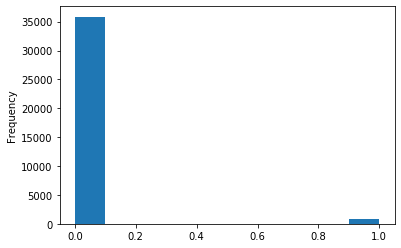

In [14]:
df_all['label'].plot(kind='hist')

- 915 Actives & 35850 decoys

## 2. Balancing dataset  

- To get a well behaved model one needs a balenced dataset, but all real world datasets have sparse data for interesting/importance events. 
- linear classifiers dont do well for outliers, this best way is to use ensemble classifiers with K-fold validation
- Using different under sampling/ over sampling methods as described in [this page](https://imbalanced-learn.org/stable/auto_examples/applications/plot_multi_class_under_sampling.html#sphx-glr-auto-examples-applications-plot-multi-class-under-sampling-py)

In [0]:
#!pip install  -U imbalanced-learn

### Undersampling Strategy: Cluster Decoys (K-Medioids) such that there are same number of actives 

#### Cluster Data with K-Means & Morgan Fingerprints



In [0]:
import numpy as np
from rdkit.Chem import AllChem, DataStructs, rdMolDescriptors

In [0]:
def molsfeaturizer(mols):
    fps = []
    for mol in mols:
        arr = np.zeros((0,))
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
        DataStructs.ConvertToNumpyArray(fp, arr)
        fps.append(arr)
    fps = np.array(fps, dtype = np.float32)
    return fps

In [0]:
fp_decoy = molsfeaturizer(list(df_decoys.ROMol))

In [0]:
from sklearn.cluster import MiniBatchKMeans, KMeans

In [0]:
kmeans = MiniBatchKMeans(n_clusters=df_active.ID.count())

In [21]:
kmeans.fit(fp_decoy)

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_kmeans.py:1576: RuntimeWarning: init_size=300 should be larger than k=915. Setting it to 3*k
  init_size=init_size)
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_kmeans.py:1576: RuntimeWarning: init_size=300 should be larger than k=915. Setting it to 3*k
  init_size=init_size)
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_kmeans.py:1576: RuntimeWarning: init_size=300 should be larger than k=915. Setting it to 3*k
  init_size=init_size)


MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=915, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [0]:
label_kmeans= kmeans.predict(fp_decoy)

In [0]:
df_decoys['Kmeans_id'] = label_kmeans

#### Agglormerative Clustering with Morgan Fingerprints, Tanimoto Similarity


### Use the Clustered Actives and Decoys for training models

,smiles,ID,ROMol,label
0,C[C@@H]1C[C@@]2(CC(C1)(C)C)C(=O)N(C(=O)N2)CC(=...,C60241483,,0
1,Cc1ccc2c(c1)CCCN2C(=O)C(=O)NC3CCC(CC3)C(=O)NC,C63432455,,0
2,Cc1ccccc1S(=O)(=O)N[C@@H]2Cc3cc(ccc3OC2)Br,C65330373,,0
3,CC(C)C(=O)Nc1ccc2c(c1)[C@@H]3C=CC[C@H]3[C@@H](...,C14467923,,0
4,CC1=C([C@@H](n2c(nnn2)N1)c3cc(ccc3OCc4ccc(cc4)...,C40978963,,0
...,...,...,...,...
31690,CNS(=O)(=O)c1ccc(c(c1)C(=O)OCc2cc3c(cc2Br)OCCO3)F,C45616343,,0
32697,COc1ccccc1[C@H]2CC3=C([C@H](Nc4ccccc4N3)c5ccc(...,C21260254,,0
33952,c1ccc2=[NH+]CC(=c2c1)CC(=O)N3CCC(CC3)[C@@H]4NN...,C64410555,,0
35301,Cc1cccc(c1)OCc2nnc(n2CC=C)SCC(=O)c3c(n(c(=O)[n...,C11496206,,0

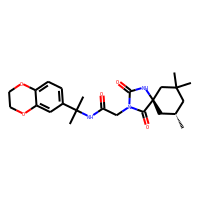
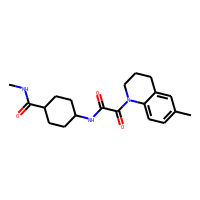
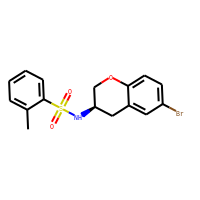
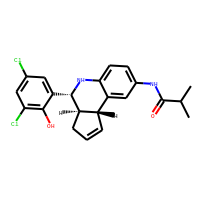
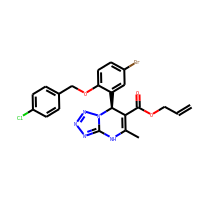
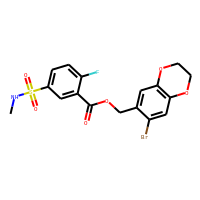
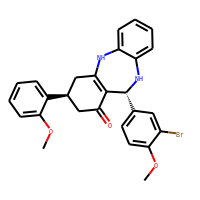
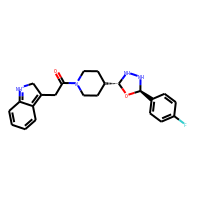
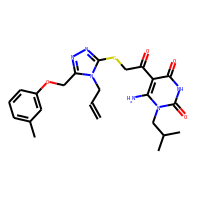
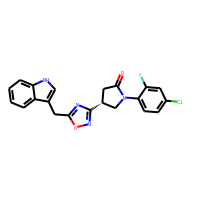

In [24]:
df_decoys.sample(frac=1).reset_index(drop=True).drop_duplicates('Kmeans_id')[['smiles','ID','ROMol','label']]

In [25]:
df_active.columns

Index(['smiles', 'ID', 'ROMol', 'label'], dtype='object')

In [0]:
df_all = pd.concat([df_decoys.sample(frac=1).reset_index(drop=True).drop_duplicates('Kmeans_id')[['smiles','ID','ROMol','label']],df_active])

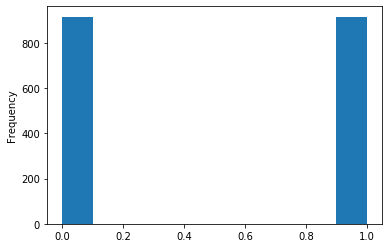

In [27]:
df_all['label'].plot(kind='hist')

In [0]:
X, y = molsfeaturizer(list(df_all['ROMol'])), np.array(list(df_all.label))

In [29]:
X.shape

(1830, 2048)

In [30]:
y.shape

(1830,)

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn import metrics
from sklearn.metrics import f1_score 

In [0]:
datasets =[(X,y)]
classifiers = [
    KNeighborsClassifier(10),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [44]:
results = {}
for i in range(len(classifiers)):
  classifiers[i].fit(X_train, y_train)
  y_pred = classifiers[i].predict(X_test)
  results[i] = [y_pred,metrics.classification_report(y_test, y_pred),metrics.roc_auc_score(y_test,y_pred)]
#  print(classifiers[i])
#  print(metrics.classification_report(y_test, y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Doing Manifold Learning with Sklearn

In [0]:
res_df = pd.DataFrame(results).T

In [0]:
res_df.columns = ['Predictions','Report','AUCscore']

In [0]:
res_df = res_df.sort_values('AUCscore')

In [54]:
res_df.tail(5)

,Predictions,Report,AUCscore
0,"[0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, ...",precision recall f1-score ...,0.963342
7,"[0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, ...",precision recall f1-score ...,0.976852
6,"[0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, ...",precision recall f1-score ...,0.986787
1,"[0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, ...",precision recall f1-score ...,0.986819
3,"[0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, ...",precision recall f1-score ...,0.990131


In [57]:
print(res_df.loc[3]['Report'])

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       299
           1       1.00      0.98      0.99       305

    accuracy                           0.99       604
   macro avg       0.99      0.99      0.99       604
weighted avg       0.99      0.99      0.99       604



In [58]:
classifiers[3]

GaussianProcessClassifier(copy_X_train=True, kernel=1**2 * RBF(length_scale=1),
                          max_iter_predict=100, multi_class='one_vs_rest',
                          n_jobs=None, n_restarts_optimizer=0,
                          optimizer='fmin_l_bfgs_b', random_state=None,
                          warm_start=False)

In [61]:
print(classifiers[1])
print(res_df.loc[1]['Report'])

SVC(C=0.025, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       299
           1       0.99      0.98      0.99       305

    accuracy                           0.99       604
   macro avg       0.99      0.99      0.99       604
weighted avg       0.99      0.99      0.99       604



In [63]:
print(classifiers[6])
print(res_df.loc[6]['Report'])

MLPClassifier(activation='relu', alpha=1, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       299
           1       0.99      0.98      0.99       305

    accuracy                           0.99       604
   macro avg       0.99      0.99      0.99       604
weighted avg       0.99      0.99      0.99       604



In [64]:
print(classifiers[7])
print(res_df.loc[7]['Report'])

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       299
           1       0.98      0.97      0.98       305

    accuracy                           0.98       604
   macro avg       0.98      0.98      0.98       604
weighted avg       0.98      0.98      0.98       604



In [65]:
print(classifiers[0])
print(res_df.loc[0]['Report'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       299
           1       0.94      0.99      0.96       305

    accuracy                           0.96       604
   macro avg       0.96      0.96      0.96       604
weighted avg       0.96      0.96      0.96       604



In [0]:
all_decoys_fp = molsfeaturizer(df_decoys.ROMol)

In [0]:
res = [classifiers[i].predict(all_decoys_fp) for i in range(len(classifiers))]